Title: What Makes The Flappy Bird Flap?   
Date: 2023-03-17   
Category: Tech   
Tags: Simulations   
Slug: modeling-flappy-bird   
Summary: If we can model a [bouncing ball]({filename}/bouncing-balls.md), what about a flapping bird?   
Status: draft   

[Previously]({filename}/bouncing-balls.md), I wrote a lot about [Hybrid Dynamic Systems](https://dl.acm.org/doi/pdf/10.1145/3337722.3337757) and simulating a simple bouncing ball.

Can we use this framework to simulate a video game? Before we dig in, the first post borrowed mostly theory from ["Analyzing Action Games: A Hybrid Systems Approach"](https://dl.acm.org/doi/pdf/10.1145/3337722.3337757) paper by Yegeta Zeleke and friends. This post is heavily based on math and implementations in the paper. I'm mostly writing up their model in Python, and leaned heavily on the [Matlab reference implementation](https://github.com/HybridSystemsLab/FlappyBirdReachability) to help me.

The Python is all mine, but the actual algorithms to solve the problem and the ideas are all theirs.

### The Model of Flappy Bird
Ok, to recap, I need four functions:  

* ```flow(...)``` tells me how the game changes over time, by taking in the current time and state, and giving me the derivative of the state with respect to time  

* ```jump(...)``` tells me how the game changes instantly, snapping from one state to another. It takes in the current time and state and returns a new state.  

* ```flow_check(...)``` tells me if the game should be flowing or not. It takes in the current time and state and returns an integer (0 for not flowing, 1 for flowing). It's gotta be an `int` to work with other libraries to use this model.  

* ```jump_check(...)``` tells me if the game should jump or not. It takes in the current time and state and returns an integer (0 for do not jump, 1 for jump). It's gotta be an `int` for the same reasons ```flow_check``` does.

All these functions deal with state... so what state does flappy bird need? We'll need both vertical and horizontal position because those will change. We'll need vertical velocity because the rate that the bird rises (or falls) changes based on time and input-- if you're pressing the flap button, you go up.

Oh! And something to track if the player is pushing the flap button or not. And, I know that eventually this all needs to be an `array-like`.

In [1]:
from collections import namedtuple

# as before, a named tuple doesn't really solve our problems
# but it does make the constructor a little nicer
# its easy enough to make a class that implements the right protocols, but compactness, yeah?
State = namedtuple('State', ['x_pos', 'y_pos', 'y_vel', 'pressed'])
state = State(x_pos=0.0, y_pos=2.0, y_vel=0.0, pressed=1)
print(state)

State(x_pos=0.0, y_pos=2.0, y_vel=0.0, pressed=1)


Ok, so let's march through, starting with `flow`. Flappy always moves right at a constant speed, so the derivative of their `x` position is a constant velocity. When they're falling, Flappy accelerates-- so when `pressed == 0`, `y` position should change according to whatever `y` velocity is, and `y` velocity should change at a magic `-9.81` acceleration due to gravity. `pressed` should never change during flows, because it only changes on jumps: new input jumps flappy to new states. Therefore, it's derivative is `0`. So flow looks a little like...

In [2]:
# delta here is just shorthand for "change in"
# what this is tracking is how the corresponding state elements change over time 
StateDerivative = namedtuple('StateDerivative', ['delta_x_pos', 'delta_y_pos', 'delta_y_vel', 'delta_pressed'])
def flow(time:float, state:State) -> tuple[float, float, float, int]:
    return StateDerivative(
        delta_x_pos=2.0, # this is a bit of an extra magic number-- its our going right constant speed.
        delta_y_pos=state[2], # this is y_vel in our state vector
        delta_y_vel=-9.81,
        delta_pressed=0
    )
# time, just like before, is arbitrary. May as well start at 0.
state_derivative = flow(0.0, State(
    x_pos=0.0,
    y_pos=2.0,
    y_vel=0.0,
    pressed=1
))
print(state_derivative)

StateDerivative(delta_x_pos=2.0, delta_y_pos=0.0, delta_y_vel=-9.81, delta_pressed=0)


But... that's only half the problem, right? What about when flappy is flapping? Flappy flaps kinda... oddly.

Flappy doesn't accelerate when they flap. They move upward at a constant velocity.

For anyone new 'round these parts: this is common in action games like platformers! It makes characters easier to control and more predictable-- if your button presses applied acceleration, rather than pure velocity, you'd need to counteract your current trajectory before going somewhere new. It'd make poor flappy a lot less agile.[^1]

So, lets add all that in:

[^1]: this isn't a bad thing-- how you program movement is a game design choice like any other, and with plenty of pros and cons.

In [3]:
def flow(time:float, state:State) -> tuple[float, float, float, int]:
    if state[3] == 0: # <-- ✨ New! ✨ not pressed
        return StateDerivative(
            delta_x_pos=2.0,
            delta_y_pos=state[2],
            delta_y_vel=-9.81,
            delta_pressed=0
        )
    # also ✨ New! ✨, this handles our pressed case
    elif state[3] == 1: #pressed
        return StateDerivative(
            delta_x_pos=2.0, 
            delta_y_pos=2.0, # just like the change in x position, this is also pretty magic
            delta_y_vel=0, # y velocity doesn't change, it's constant while flapping!
            delta_pressed=0 
        )
    else:
        raise RuntimeError(f"Invalid state! {state}, pressed != 0 or 1")
    
unpressed_state_derivative = flow(0.0, State(
    x_pos=0.0,
    y_pos=2.0,
    y_vel=0.0,
    pressed=0
))
print("How we flow when the flap button is not pressed:")
print(unpressed_state_derivative)
print("\n")
pressed_state_derivative = flow(0.0, State(
    x_pos=0.0,
    y_pos=2.0,
    y_vel=0.0,
    pressed=1 #<-- ✨ note the difference! ✨
))
print("How we flow when the flap button is pressed:")
print(pressed_state_derivative)

How we flow when the flap button is not pressed:
StateDerivative(delta_x_pos=2.0, delta_y_pos=0.0, delta_y_vel=-9.81, delta_pressed=0)


How we flow when the flap button is pressed:
StateDerivative(delta_x_pos=2.0, delta_y_pos=2.0, delta_y_vel=0, delta_pressed=0)


That seems about right to me! And since we're here, let's do `flow_check`... once again, this function has big "you're pranking me" energy.

In [4]:
def flow_check(time:float, state:State) -> int:
    # yeah, we're always flowing again. 🙃
    return 0

Ok, `jump` time. Well, flappy only jumps when we provide input. We need to both record that in the state, so we'll flow correctly, and also set flappy's `y` velocity to what it should be when the button is pressed.

`jump_check` is... just gonna never jump for now. We can check to make sure flappy falls correctly before adding more complex logic.

In [5]:
def jump(time:float, state:State) -> tuple[float, float, float, int]:
    # a jump is the instant when the flap button is pressed
    new_pressed = abs(state[3] - 1) # a bit of a trick to flip 1 to 0 and 0 to 1. Not efficient. That'll come up later 
    if new_pressed == 1: #if we're going from not pressed to pressed...
        return State(
            x_pos=state[0],
            y_pos=state[1],
            y_vel=2.0, # using the same magic number as our rightward velocity! 
            pressed=new_pressed
        )
    else:
        return State(
            x_pos=state[0],
            y_pos=state[1],
            y_vel=state[2],
            pressed=new_pressed # almost an exact copy, except we change the pressed flag
        )
    
def jump_check(time:float, state:State) -> int:
    return 1 # never jump for now

old_state = State(
    x_pos=0.0,
    y_pos=2.0,
    y_vel=0.0,
    pressed=0
)
new_pressed_state = jump(0.0, old_state)
print("For pressing the button:")
print(f"Jumping from {old_state}")
print(f"to {new_pressed_state}")
print("----------")

old_state = State(
    x_pos=0.0,
    y_pos=2.0,
    y_vel=0.0,
    pressed=1
)
new_released_state = jump(0.0, old_state)
print("For releasing the button:")
print(f"Jumping from {old_state}")
print(f"to {new_released_state}")

For pressing the button:
Jumping from State(x_pos=0.0, y_pos=2.0, y_vel=0.0, pressed=0)
to State(x_pos=0.0, y_pos=2.0, y_vel=2.0, pressed=1)
----------
For releasing the button:
Jumping from State(x_pos=0.0, y_pos=2.0, y_vel=0.0, pressed=1)
to State(x_pos=0.0, y_pos=2.0, y_vel=0.0, pressed=0)


Alright. I'm gonna steal the `Hybrid System` and `System Parameters` structs from [the last article]({filename}/bouncing-balls.md). And while I'm there, lets snag the `solve_system` function too. And the graphing code, so we can see what this system does.

aaaannnnnnd

In [7]:
# this cell is ignored, and is a big mess of functions to run ye hybrid system, dump results to a file and graph it
from typing import Any, Callable, List
from dataclasses import dataclass
from scipy import integrate
import csv

@dataclass
class HybridSystem():
    """ Collect all our functions into one structure for ease of being able to remember things later.
    """
    flow: Callable
    flow_check: Callable
    jump: Callable
    jump_check: Callable

@dataclass
class SystemParameters():
    """ Setting up some stopping points: what our time interval to solve over should be, and the maximum
        number of jumps we want to have before we call it quits.
        Should probably just be an attribute of the hybrid system up there
    """
    start_time: float
    end_time: float
    max_jumps: int

def solve_system(system:HybridSystem, params:SystemParameters, start_state:State) -> list[Any]:
    solution:List[Any] = [] # gradual typing is neat!
    cur_time = params.start_time
    number_of_jumps = 0
    state = start_state

    while (cur_time < params.end_time and number_of_jumps < params.max_jumps):
        if(system.flow_check(cur_time, state) == 0):
            ode_sol = integrate.solve_ivp(
                system.flow,
                (cur_time, params.end_time),
                state,
                # ✨ New! ✨
                events=[system.jump_check],
                max_step=0.01,
                atol=1e-6,
                rtol=1e-6
            )
            if ode_sol.status == -1:
                print(f"Solver failed with message: {ode_sol.message}")
                return solution
            for time, state in zip(ode_sol.t, ode_sol.y.T):
                solution.append((time, state))

            cur_time, state = solution[-1] # the last element in the solution is our new current state

        # if we're not flowing, we, by definition, must be jumping. In practice, we want some
        # stronger asserts here to prevent infinite loops
        if (system.jump_check(cur_time, state) == 0):
            state = jump(cur_time, state)
            number_of_jumps += 1
    
    return solution

def write_csv(solution: list, filepath: str):
    with open(filepath, "w") as f:
        writer = csv.DictWriter(f=f, fieldnames=["time", "x_pos", "y_pos", "y_vel", "pressed"])
        writer.writeheader()
        for time, state in solution:
            writer.writerow({
                "time": time,
                "x_pos": state[0],
                "y_pos": state[1],
                "y_vel": state[2],
                "pressed": state[3]
            })

flappy_bird_hybrid_system = HybridSystem(flow, flow_check, jump, jump_check)
hybrid_system_params = SystemParameters(0.0, 1.0, 5)
start_state = State(x_pos=0.0, y_pos=2.0, y_vel=0.0, pressed=0.0)
solution = solve_system(flappy_bird_hybrid_system, hybrid_system_params, start_state)
write_csv(solution, "../tmp/flapping_birds_falling_birds.csv")

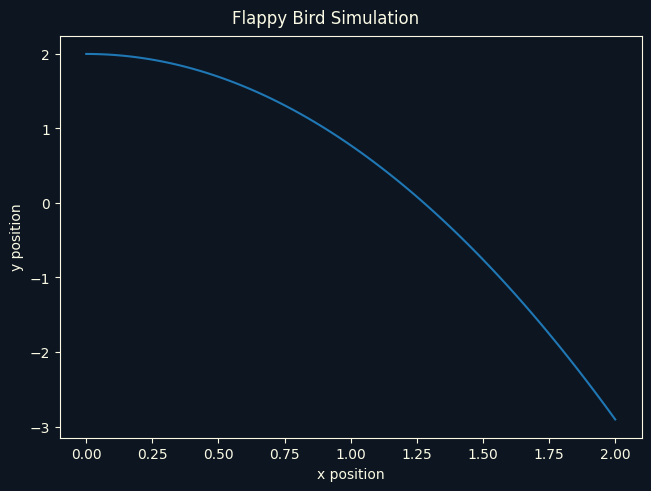

In [8]:
# util code!
from util.columnar import Columnar
from util.palette import blog_palette
from util.graph import Graph
from pathlib import Path
from dataclasses import dataclass, field


@dataclass
class SimData(Columnar):
    """ Transforming our data a little bit. Matplotlib plays nicer with iterables
        for each dimension, rather than one iterable where each element is an array
    """
    time: list[float]=field(default_factory=list)
    x_pos: list[float]=field(default_factory=list)
    y_pos: list[float]=field(default_factory=list)
    y_vel: list[float]=field(default_factory=list)
    pressed: list[int]=field(default_factory=list)

animated_path_css_fmt = """.{style_name}{{
        stroke:{stroke_color};
        stroke-width:1.5;
        stroke-linecap:square;
        fill:{fill_color};
        fill-opacity:0;
        stroke-dasharray:140%;
        stroke-dashoffset:140%;
        animation-name:path-anim;
        animation-duration:5s;
        animation-timing-function:linear;
        animation-fill-mode:forwards;
        animation-iteration-count: infinite;
    }}
    @keyframes path-anim{{
        0%{{
            stroke-dashoffset:140%;
        }}
        65%{{
            stroke-dashoffset:0%;
        }}
        100%{{
            stroke-dashoffset:0%;
        }}
    }}
    """

block_css_fmt = """.{style_name}{{
        "stroke":{stroke_color};
        fill:{fill_color};
    }}
    """

data = SimData.from_csv(
    Path("../tmp/flapping_birds_falling_birds.csv")
)
graph = Graph(
    background=blog_palette["background"],
    foreground=blog_palette["foreground"],
    title="Flappy Bird Simulation",
    figures=[(1,1,1)]
)
graph.set_axis_labels(0, "y position", "x position")
plotted_ids = graph.plot(0, data.x_pos, data.y_pos, "flappy-height")
for id in plotted_ids:
    graph.add_style(
        id,
        animated_path_css_fmt,
        {
            "style_name": "animated_path",
            "stroke_color": blog_palette["foreground"],
            "fill_color": blog_palette["background"]
        }
    )
graph.save(Path("../content/images/flapping_birds_falling_birds.svg"))

![An animated graph of a very sad run of flappy bird]({static}/images/flapping_birds_falling_birds.svg)

Ok, well, that's not the most compelling graph I've seen in my entire life. Once again, we're going under 0, when that's our unofficial death floor. There's also no obstacles. Or even flapping.

Let's start with the last thing because it's in the name: let's make this flappy bird flap.

### Making Flappy Bird Flap

We use the `jump` function to move to the "flapping" state from the "falling" state (and from "falling" back to "flapping"). We know we _should_ be jumping when `jump_check` says so.

So, when do we want `jump_check` to be 1? Well, lets just say it should be one between certain times to start, which sorta says "after 0.5 time units from when the sim starts, a player presses the flap button. They release it at 0.6 time units".

In [9]:
def jump_check(time:float, state:State) -> int:
    # ✨ New! ✨
    # we know our sim runs from time 0 to time 1, for right now. lets hardcode two jumps, one to set the "pressed"
    # element in our state vector, and one to unset it
    
    # if the button isn't being pressed, and we're in the range where we want it to be pressed
    # say that we need to jump to press it
    if time >= 0.5 and time < 0.6 and state[3] != 1:
        return 0
    # and the reverse is true here, although we only care about time after the pressing
    elif time >= 0.6 and state[3] != 0:
        return 0
    # otherwise we're not jumping
    else:
        return 1
    
jump_check.terminal = True # required for scipy

In [10]:
flappy_bird_hybrid_system = HybridSystem(flow, flow_check, jump, jump_check)
hybrid_system_params = SystemParameters(0.0, 1.0, 5)
start_state = State(x_pos=0.0, y_pos=2.0, y_vel=0.0, pressed=0.0)
solution = solve_system(flappy_bird_hybrid_system, hybrid_system_params, start_state)
write_csv(solution, "../tmp/flapping_birds_single_flap.csv")

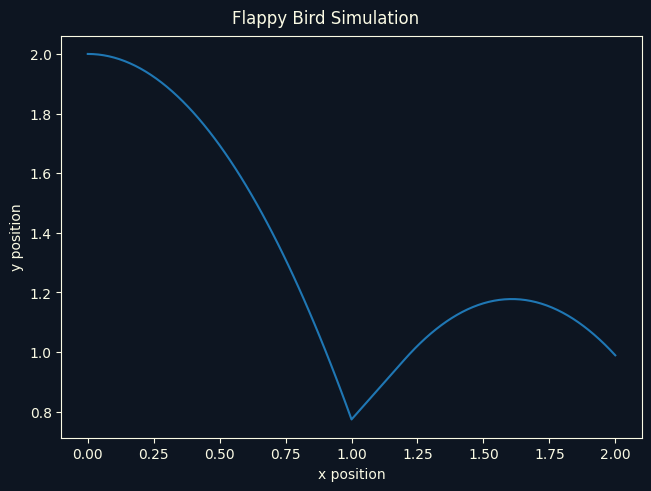

In [11]:
data = SimData.from_csv(
    Path("../tmp/flapping_birds_single_flap.csv"),
)
graph = Graph(
    background=blog_palette["background"],
    foreground=blog_palette["foreground"],
    title="Flappy Bird Simulation",
    figures=[(1,1,1)]
)
graph.set_axis_labels(0, "y position", "x position")
plotted_ids =  graph.plot(0, data.x_pos, data.y_pos, "flappy-height")
for id in plotted_ids:
    graph.add_style(
        id,
        animated_path_css_fmt,
        {
            "style_name": "animated_path",
            "stroke_color": blog_palette["foreground"],
            "fill_color": blog_palette["background"]
        }
    )
graph.save(Path("../content/images/flapping_birds_single_flap.svg"))

![An animated graph of a simulation where flappy makes a single jump]({static}/images/flapping_birds_single_flap.svg)

Alright, that's starting to look a little better. Obviously, hardcoding jump points isn't where we want to be in life, but hey! Flappy has a trajectory that looks sane!

Now we need collision detection, so the simulation stops when Flappy hits the bottom or top of the screen.

### Making Flappy Bird Die
So, uh, how are we going to do this? We could have a new state, `dead` and jump to it when flappy collides with the floor or roof. But, that'll lead to a lot of wasted work after we get into the `dead` state: the sim will still spin forward until it gets to `end_time` with noting meaningful to do. We want to stop the sim early.

We know that `jump_check` stops the sim early (with ```jump_check.terminal = True```), so collision is like a jump where we just stop simulating[^2]. Let's add a collision detection function and modify both `jump_check` and `solve_system`:

[^2]: this is obviously not true in general-- collision can be a jump to a state where you can no longer continue on your current trajectory (hitting a wall). Maybe you get some invulnerability frames and jump to a state with less life.

In [12]:
 # ✨ New! ✨ Check to see if we're colliding with anything and need to die
def check_collision(state:State) -> bool:
    # the "height" of the level is gonna be a little arbitrary and hardcoded for now
    # as always, y position of 0 is our floor and means death
    if state[1] <= 0.0 or state[1] >= 5.0:
        return True
    else:
        return False

# lets change jump_check to identify collisions  
def jump_check(time:float, state:State) -> int:
    # ✨ New! ✨
    if check_collision(state):
        return 0
 
    if time >= 0.5 and \
        time < 0.6 and \
            state[3] != 1:
        return 0
    elif time >= 0.6 and \
        state[3] != 0:
        return 0
    else:
        return 1
jump_check.terminal = True # we've got a new function, so we need to set this again

# and now we also need to change solve_system to distinguish between solution stops-- did we
# stop flowing because we hit something or because we started jumping?
def solve_system(system:HybridSystem, params:SystemParameters, start_state:State) -> list[Any]:
    solution:list[Any] = [] # gradual typing is neat!
    cur_time = params.start_time
    number_of_jumps = 0
    state = start_state

    while (cur_time < params.end_time and number_of_jumps < params.max_jumps):
        if(system.flow_check(cur_time, state) == 0):
            ode_sol = integrate.solve_ivp(
                system.flow,
                (cur_time, params.end_time),
                state,
                events=[system.jump_check],
                max_step=0.01,
                atol=1e-6,
                rtol=1e-6
            )
            if ode_sol.status == -1:
                print(f"Solver failed with message: {ode_sol.message}")
                return solution
            for time, state in zip(ode_sol.t, ode_sol.y.T):
                solution.append((time, state))

            cur_time, state = solution[-1]
        
        # ✨ New! ✨
        # check_collision is very cheap, so this call isn't too outrageous. In real games, collision detection
        # is expensive. We'd probably only want to call it once, jump to a dead state, and check if we died
        # at the top of the loop instead.
        if check_collision(state):
            return solution
        
        if (system.jump_check(cur_time, state) == 0):
            state = jump(cur_time, state)
            number_of_jumps += 1
    
    return solution

In [13]:
flappy_bird_hybrid_system = HybridSystem(flow, flow_check, jump, jump_check)
# ✨ New! ✨ setting a much longer end time, we should stop before we get there!
hybrid_system_params = SystemParameters(0.0, 5.0, 5)
start_state = State(x_pos=0.0, y_pos=2.0, y_vel=0.0, pressed=0.0)
solution = solve_system(flappy_bird_hybrid_system, hybrid_system_params, start_state)
write_csv(solution, "../tmp/flapping_birds_single_flap_long.csv")

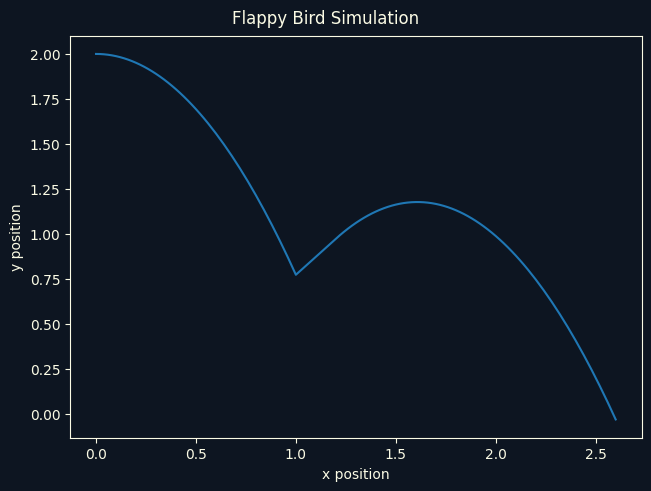

In [14]:
data = SimData.from_csv(
    Path("../tmp/flapping_birds_single_flap_long.csv")
)
graph = Graph(
    background=blog_palette["background"],
    foreground=blog_palette["foreground"],
    title="Flappy Bird Simulation",
    figures=[(1,1,1)]
)
graph.set_axis_labels(0, "y position", "x position")
plotted_ids = graph.plot(0, data.x_pos, data.y_pos, "flappy-height")
for id in plotted_ids:
    graph.add_style(
        id,
        animated_path_css_fmt,
        {
            "style_name": "animated_path",
            "stroke_color": blog_palette["foreground"],
            "fill_color": blog_palette["background"]
        }
    )
graph.save("../content/images/flapping_birds_single_flap_long.svg")

![A graph showing one big long flappy bird flap, until the poor bird plummets to death]({static}/images/flapping_birds_single_flap_long.svg)

### Stuff To Dodge

Having an upper and lower bound is all well and good, but really Flappy Bird is hard because there are pipes to dodge. Flap around. We need to add some obstacles, but we don't really need things like "sprites", "graphics" or "art" in simulation land. We just care that there are some rectangular death zones spaced somewhat regularly apart.

I could start by hardcoding the pipe locations just like the level boundaries, but uuuuh. Look, I didn't love hardcoding in the boundaries in the last part and I want to eventually graph where the death zones are. It's time for some data structures.

In [15]:
from pprint import pprint
@dataclass
class BoundingBox():
    """ Its a rectangle! Represented by the top left point, a width and a height
    """
    top_left: tuple[float, float]
    width: float
    height: float

@dataclass
class FlappyLevel():
    """ It's a flappy bird level! We get a ceiling (going too high means death),
        a floor (going too low means death), and a list of obstacles (touching means death)
    """
    floor:float
    ceiling:float
    obstacles: list[BoundingBox]

sample_level = FlappyLevel(
    floor=0.0,
    ceiling=5.0,
    obstacles=[
        BoundingBox(
            top_left=(1.0, 5.0),
            width=0.5,
            height=3.5
        ),
        BoundingBox(
            top_left=(1.5, 0.75),
            width=0.5,
            height=0.75
        )
    ]
)
pprint(sample_level)

FlappyLevel(floor=0.0,
            ceiling=5.0,
            obstacles=[BoundingBox(top_left=(1.0, 5.0), width=0.5, height=3.5),
                       BoundingBox(top_left=(1.5, 0.75),
                                   width=0.5,
                                   height=0.75)])


Ok, not the prettiest printing of all time there, but it'll do. Now, we need to update our `jump_check` function to actually use it. So, let's just add an argument-- oh.

well, uh.

hm.

Remember that `jump_check` must be in a very particular form because it's going to get called by `scipy` owned code as a part of `solve_ivp`. We can't just add an argument, the solver doesn't know anything about the level. There are a few ways to go forward here:
1. we control how `jump_check` executes and what it's scope is. We can save the level as a variable that's in scope while `jump_check` is doing its thing
2. that, but more formal: classes and objects

Which means, ugh, variable lifetime and all the other annoying things you need to start thinking about when you move from beyond easy "function only operates on its arguments" land[^3]. Eventually, we're going to want to run many simulations on one level, so wrapping up everything as a "simulation" class makes sense to me. The stuff that stays the same from run to run becomes class attributes, and we can pass the stuff that differs to a `solve_system` instance method.

Because [bound methods of instances](https://docs.python.org/3.11/reference/datamodel.html#instance-methods) work like a regular old callable from the outside, we can have the object "ride along" with invocation, with our solver being non-the-wiser [^4]

Does that make sense? I hope so. 3,2,1, let's jam.

[^3]: The Haskell people were right, this sucks

[^4]: this behavior is not free-- I do pay a penalty for passing in the instance as the first argument, but lord, do I have bigger problems elsewhere.

In [16]:
from util.print import blog_print
from dataclasses import dataclass

@dataclass
class SystemParameters:
    start_time: float
    end_time: float
    max_jumps: int

    # ✨ New! ✨ moving hardcoded terms out to this parameters structure
    pressed_velocity: float # how fast should flappy rise when the button is pressed?
    horizontal_velocity: float # how fast should flappy go to the right
    gravity_acceleration:float # acceleration due to gravity

class FlappyHybridSim:
    """ This simulation class combines all the simulation constants: level, simulation parameters and ye four
        functions.
    """
    level: FlappyLevel
    cur_params: SystemParameters | None # only gets set while we're in solve_system, None otherwise
    # why aren't these in system params? They don't change! I want to keep these the same
    # across many simulation runs
    max_step:float
    atol:float
    rtol:float

    def __init__(self, level:FlappyLevel):
        self.level = level
        self.cur_params = None
        self.max_step=0.01
        self.atol=1e-6
        self.rtol=1e-6
        

    # ✨ New! ✨ logic to make sure we're not hitting a box, and integration with our level data structure
    def solve_system(self, params:SystemParameters, start_state:State) -> list[Any]:
        solution:list[Any] = [] # gradual typing is neat!
        self.cur_params = params
        cur_time = params.start_time
        number_of_jumps = 0
        state = start_state

        if(self._flow_check(cur_time, state) == 0):
            ode_sol = integrate.solve_ivp(
                self._flow,
                (cur_time, params.end_time),
                state,
                events=[self._jump_check],
                max_step=self.max_step,
                atol=self.atol,
                rtol=self.rtol
            )
            if ode_sol.status == -1:
                print(f"Solver failed with message: {ode_sol.message}")
                return solution
            for time, state in zip(ode_sol.t, ode_sol.y.T):
                solution.append((time, state))

            cur_time, state = solution[-1]
         
            if self._check_collision(state):
                self.cur_params = None
                return solution
        
            if (self._jump_check(cur_time, state) == 0):
                state = self._jump(cur_time, state)
                number_of_jumps += 1
        self.cur_params = None 
        return solution
    
    # ✨ New! ✨ We're integrating the level into this function!
    def _check_collision(self, state:State) -> bool:
        if state[1] <= self.level.floor or state[1] >= self.level.ceiling:
            return True
        
        # we need to actually see if we're inside a death box or not
        # in a real game, we'd want to do a location based query (tell me what's nearby so I only check against nearby
        # things) but our level is so simple right now, we can just test against all the geometry
        for box in self.level.obstacles:
            # I'm like 99% sure there's a way to rephrase this hellish if statement
            # this'll get called within our solver, so state has lost it's nice property names :c
            if state[0] >= box.top_left[0] and \
                state[0] <= box.top_left[0] + box.width and \
                state[1] >= box.top_left[0] and \
                state[1] <= box.top_left[1] + box.height:
                return True

        return False

    # our four hybrid system functions have been refactored to work with the new constants in
    # self.cur_params (and also get an _ prefix to say: "hey, don't call this")
    def _flow(self, time:float, state:State) -> tuple[float, float, float, int]:
        # this little test shows that our extra flexibility-- moving things like
        # horizontal velocity to a passed in parameter-- is not free: we have an extra check
        # to perform now
        if not self.cur_params:
            raise RuntimeError("Unable to get run parameters!")

        if state[3] == 0:
            return StateDerivative(
                delta_x_pos=self.cur_params.horizontal_velocity,
                delta_y_pos=state[2],
                delta_y_vel=self.cur_params.gravity_acceleration,
                delta_pressed=0
            )
        elif state[3] == 1: #pressed
            return StateDerivative(
                delta_x_pos=self.cur_params.horizontal_velocity, 
                delta_y_pos=self.cur_params.pressed_velocity,
                delta_y_vel=0,
                delta_pressed=0 
            )
        else:
            raise RuntimeError(f"Invalid state! {state}, pressed != 0 or 1")

    def _flow_check(self, time:float, state:State) -> int:
        return 0

    def _jump(self, time:float, state:State) -> tuple[float, float, float, int]:
        if not self.cur_params:
            raise RuntimeError("Unable to get runtime parameters!")

        new_pressed = abs(state[3] - 1)
        if new_pressed == 1:
            return State(
                x_pos=state[0],
                y_pos=state[1],
                y_vel=self.cur_params.pressed_velocity,
                pressed=new_pressed
            )
        else:
            return State(
                x_pos=state[0],
                y_pos=state[1],
                y_vel=state[2],
                pressed=new_pressed
            )
    
    def _jump_check(self, time:float, state:State) -> int:
        if self._check_collision(state):
            return 0
 
        if time >= 0.5 and \
            time < 0.6 and \
                state[3] != 1:
            return 0
        elif time >= 0.6 and \
            state[3] != 0:
            return 0
        else:
            return 1
    _jump_check.terminal = True

single_run_params = SystemParameters(
    start_time=0.0,
    end_time=5.0,
    max_jumps=5,
    pressed_velocity=2.0,
    horizontal_velocity=2.0,
    gravity_acceleration=-9.81
)
start_state = State(x_pos=0.0, y_pos=2.0, y_vel=0.0, pressed=0.0)
sim = FlappyHybridSim(sample_level)
solution = sim.solve_system(single_run_params, start_state)
blog_print(solution, lambda line: f"State at {line[0]:0.04f}: {[f'{val:0.04f}' for val in line[1]]}")

State at 0.0000: ['0.0000', '2.0000', '0.0000', '0.0000']
State at 0.0100: ['0.0200', '1.9995', '-0.0981', '0.0000']
State at 0.0200: ['0.0400', '1.9980', '-0.1962', '0.0000']
...
State at 0.4800: ['0.9600', '0.8699', '-4.7088', '0.0000']
State at 0.4900: ['0.9800', '0.8223', '-4.8069', '0.0000']
State at 0.5000: ['1.0000', '0.7737', '-4.9050', '0.0000']


In [21]:
from util.export.export import blog_export
# holding onto the jupyter magic _ih[len(_ih) - 2] for getting cell input
# PICK UP THE EXPORT SAGA HERE-- the sim doesn't have the right annotations for its attributes, but we can fix that! Maybe!
blog_export(FlappyHybridSim, Path("./tmp/modeling_flappy_bird"))

TOP LEVEL OF BLOG EXPORT
<class '__main__.FlappyHybridSim'>
base type: <class '__main__.FlappyLevel'>
differing <class '__main__.FlappyLevel'>
base type: <class 'types.UnionType'>
base type: <class '__main__.SystemParameters'>
differing <class '__main__.SystemParameters'>
base type: <class 'NoneType'>
base type: <class 'float'>
base type: <class 'float'>
base type: <class 'float'>
base type: <class '__main__.FlappyLevel'>
differing <class '__main__.FlappyLevel'>
base type: <class '__main__.State'>
differing <class '__main__.State'>
base type: <class 'bool'>
differing <class '__main__.StateDerivative'>
base type: <class 'float'>
base type: <class '__main__.State'>
differing <class '__main__.State'>
base type: <class 'tuple'>
base type: <class 'float'>
base type: <class 'float'>
base type: <class 'float'>
base type: <class 'int'>
base type: <class 'float'>
base type: <class '__main__.State'>
differing <class '__main__.State'>
base type: <class 'int'>
differing <class '__main__.State'>
ba

In [20]:
blog_export(FlappyLevel, Path("./tmp/modeling_flappy_bird"))

TOP LEVEL OF BLOG EXPORT
<class '__main__.FlappyLevel'>
base type: <class 'float'>
base type: <class 'float'>
base type: <class 'list'>
base type: <class '__main__.BoundingBox'>
differing <class '__main__.BoundingBox'>
skip __eq__, couldn't get source code for it. May be generated by Python
skip __init__, couldn't get source code for it. May be generated by Python
skip __repr__, couldn't get source code for it. May be generated by Python
TOP LEVEL OF BLOG EXPORT
<class '__main__.BoundingBox'>
base type: <class 'tuple'>
base type: <class 'float'>
base type: <class 'float'>
base type: <class 'float'>
base type: <class 'float'>
skip __eq__, couldn't get source code for it. May be generated by Python
skip __init__, couldn't get source code for it. May be generated by Python
skip __repr__, couldn't get source code for it. May be generated by Python


Ugh, as a graph, please?

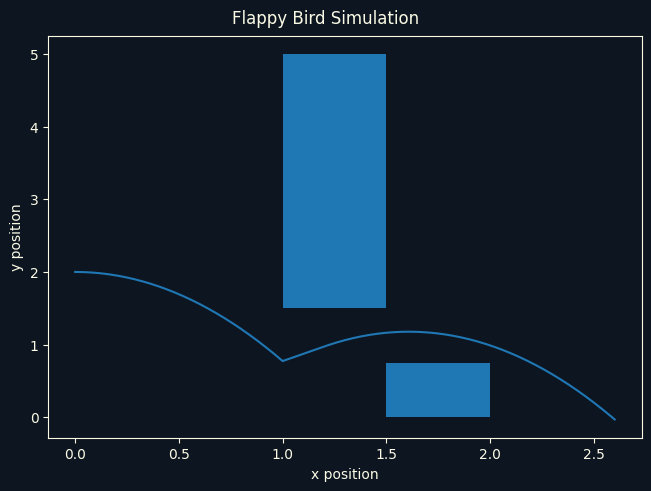

In [17]:
write_csv(solution, "../tmp/flapping_birds_single_flap_level.csv")
data = SimData.from_csv(
    Path("../tmp/flapping_birds_single_flap_long.csv")
)
graph = Graph(
    background=blog_palette["background"],
    foreground=blog_palette["foreground"],
    title="Flappy Bird Simulation",
    figures=[(1,1,1)]
)
graph.set_axis_labels(0, "y position", "x position")
for idx, bbox in enumerate(sim.level.obstacles):
    box_id = f"flappy-pipe-{idx}"
    graph.add_rectangle(0, bbox.top_left, bbox.width, bbox.height, box_id)
    graph.add_style(
        box_id,
        block_css_fmt,
        {
           "style_name": "pipe",
           "stroke_color": blog_palette["foreground"],
           "fill_color": blog_palette["background_var"] 
        }
    )
plotted_ids = graph.plot(0, data.x_pos, data.y_pos, "flappy-height")
for id in plotted_ids:
    graph.add_style(
        id,
        animated_path_css_fmt,
        {
            "style_name": "animated_path",
            "stroke_color": blog_palette["foreground"],
            "fill_color": blog_palette["background"]
        }
    )

graph.save("../content/images/flapping_birds_single_flap_level.svg")

![A very silly level of flappy bird, where we have two pipes that flappy narrowly skips through]({static}/images/flapping_birds_single_flap_level.svg)

Ok, well, it's not the best level of all time but it is a level! I'm gonna make a better level. And just as a fun little treat, what if I didn't have to write a Flappy bird level by hand each time? I don't really have a good way to do that, after all. Writing out all that level data by hand in Python isn't a super funky fresh time. What if I had a little procedural level generation, as a treat?

### A Little Procedural Level Generation, as a Treat

Procedural level generation, it's aesthetics and dynamics, what its good at and what its bad at, is a debated topic. I'm mostly writing a level generator as a replacement for writing a level design tool-- and also because the original matlab had one, so I don't have to think too hard about an algorithm[^5]

[^5]: ok, a look behind the curtain: I originally wrote this whole simulation system in Python last year. I've only recently started rewriting everything up as these blog posts. As part of my original work, I wrote a procedural level generation system. I have the Python code here. I _swore_ I cribbed it from the original paper's [Matlab reference implementation](https://github.com/HybridSystemsLab/FlappyBirdReachability). But, now that I'm writing this blog post, I can't find it. The Matlab code has five fixed choices for a simulation level, but no procedure for generating one on the fly. I'm still not convinced that I came up with this, not that it's particularly clever but I'm particularly dumb. I'm sticking to my story.

Here's a weird thing about Flappy Bird levels: the pipes are always aligned with each other. My mismatched death boxes never happens. It also kinda looks like the pipes are _regularly_ spaced apart, too. I'm gonna mark up a [screenshot from a Java clone of the original Flappy Bird](https://github.com/williamfiset/FlappyBird) with some distance relationships in a snippet:

![A marked up screenshot of Flappy Bird, pointing out how the horiztonal distance between pipes is always the same, and the vertical gap between pipes is also always the same]({static}/images/flappy_markup_markup.png)

The horizontal distance between pipes is always the same, and the vertical gap between pipes is also always the same. There's a minimum height for a pipe to be, and a corresponding maximum height. Flappy Bird levels aren't very random at all, when you look at it. So, uh, what might an algorithm for generating a level look like?

Well, I can place a pair of pipes, a top pipe and bottom pipe, at some regular interval. Say, uh, 2. So, the first pair of pipes would go at, say, x position 1. Then the next pair of pipes would go in at `1 + pipe_width + 2`. The third pipe would go at `(1 + pipe_width + 2) + pipe_width + 2`, and so on. It's recursive! Gotta love to see it.

For heights, we know there's always a fixed gap between pipes... lets say, 1. We know there's a minimum pipe height, let's also make that 1. We can than randomly pick a bottom pipe hight from 1 - 3, and we can figure out our top pipe hight by all the constraints we've placed (keeping with our convention that the ceiling is at 5, and the floor is at 0). if the bottom pipe is 1 tall, then there's a gap of 1, which means the top pipe must be 3 tall. And because the top pipe must always have at least a hight of 1 and that there must always be a gap of at least 1, the bottom pipe can't be any taller than 3.

It's a little funny how deeply constrained this whole thing is, at least to me. Let's write some Python:

In [18]:
import random
from typing import Optional

def generate_flappy_level(seed: Optional[int]) -> FlappyLevel:
    # hold up partner, what's that seed argument?
    # it's a magic number to kick off random choices-- rnd(seed) will always give the same sequence of numbers.
    # this is mostly useful for developers to get repeatable behavior from code that needs randomness for debugging
    # or evaluation. It's also used by Slay the Spire players to find unwinnable games.
    if seed: random.seed(seed)

    # this is a bunch of stuff that should be parameters (really, wrapped up in a struct as like FlappyLevelGenParams or some such)
    # but works well enough for explaining the procedure
    lower_bound: float = 0.0
    upper_bound: float = 5.0
    x_start: float = 1.0
    x_period: float = 2.0
    heights: List[float] = [1, 1.5, 2, 2.5, 3] # breaking down our "random height from 1-3" into five distinct choices. It'll add a little chop to the level, which I think is good, actually
    
    pipe_width: float = 0.7
    gap: float = 1.0
    num_gaps: int = 6 # this is the size of our level, in terms of "number of gaps between pipes to clear".
                      # As we'll see later, this is more than long enough before we hit other problems.

    pipes = []
    for i in range(num_gaps):
        left_side = x_start + x_period * i
        bottom_pipe_height = random.choice(heights)
        top_pipe_height = upper_bound - (bottom_pipe_height + gap)
        pipes.append(BoundingBox((left_side, bottom_pipe_height), pipe_width, bottom_pipe_height))
        pipes.append(BoundingBox((left_side, upper_bound), pipe_width, top_pipe_height))

    return FlappyLevel(lower_bound, upper_bound, pipes)

hybrid_system_params = SystemParameters(0.0, 5.0, 5)
start_state = State(x_pos=0.0, y_pos=2.0, y_vel=0.0, pressed=0.0)
generated_level = generate_flappy_level(99)
sim = FlappyHybridSim(generated_level)
solution = sim.solve_system(hybrid_system_params, start_state)

TypeError: SystemParameters.__init__() missing 3 required positional arguments: 'pressed_velocity', 'horizontal_velocity', and 'gravity_acceleration'

In [ ]:
write_csv(solution, "../tmp/flapping_birds_single_flap_gen_level.csv")
data = SimData.from_csv(
    Path("../tmp/flapping_birds_single_flap_gen_level.csv")
)
graph = Graph(
    background=blog_palette["background"],
    foreground=blog_palette["foreground"],
    title="Flappy Bird Simulation",
    figures=[(1,1,1)]
)
graph.set_axis_labels(0, "y position", "x position")
for idx, bbox in enumerate(sim.level.obstacles):
    box_id = f"flappy-pipe-{idx}"
    graph.add_rectangle(0, bbox.top_left, bbox.width, bbox.height, box_id)
    graph.add_style(
        box_id,
        block_css_fmt,
        {
           "style_name": "pipe",
           "stroke_color": blog_palette["foreground"],
           "fill_color": blog_palette["background_var"] 
        }
    )
plotted_ids = graph.plot(0, data.x_pos, data.y_pos, "flappy-height")
for id in plotted_ids:
    graph.add_style(
        id,
        animated_path_css_fmt,
        {
            "style_name": "animated_path",
            "stroke_color": blog_palette["foreground"],
            "fill_color": blog_palette["background"]
        }
    )

graph.save("../content/images/flapping_birds_single_flap_gen_level.svg")

![A much longer and more drawn out level of flappy bird, where flappy eats shit immediately]({static}/images/flapping_birds_single_flap_gen_level.svg)

Yeah, just like that! We can even watch our poor sim bomb out now that the "pipes" are in a more correct place.

Huh.

Maybe we should like, figure out how to [control Flappy the Bird better than just hardcoding the poor avian]({filename}/steering-birds.md). 